<a href="https://colab.research.google.com/github/itzeluky07/Final-Project/blob/main/ProyectoFinalItzel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bio-Scale**
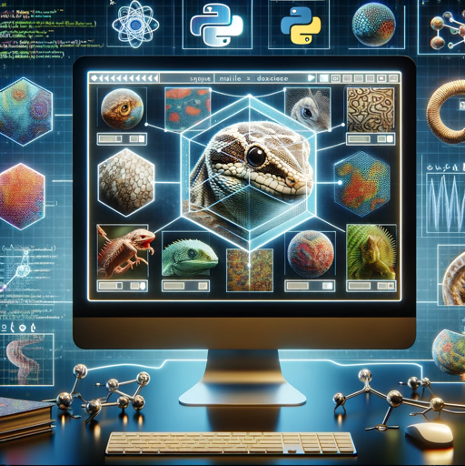
*

Goals of this code and project is develop a machine learning model to be able to classify image sif animals with the detection scales in the animals.*

# **1.**
In the first part of the code I installed some powerful libraries to be able to create later a model to classify the images, to create some graphs to understand the model and train the data

In [ ]:
!pip install tensorflow keras numpy pillow
!pip install matplotlib

# **2.**
In the second part of the code I import some libraries to be able to work in the next part of code. I decided to to put all the libraries in just one section of the code to not repeat lines.

In [ ]:
import os # to interact with the operating system, like managing file paths.
import json #to handle JSON files for parsing and loading data.
import shutil #for moving files.
from zipfile import ZipFile #to handle ZIP files for extraction.
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter



# **3.**
In the third part of the code I extracted the free data from the archive.zip file that I got from the Kaggle.In the zip file we have multiples files with name of animal in the scientific form and .json file with the translation of the scientific names to the common names. For that reason I load the content of the JSON file to rename and reorganize the file with the images of animals according to the comon name to be easier put in code what animals have scales.
References:SAJIV MENON, S. (2022). Animals 151 [Dataset]. Kaggle. https://www.kaggle.com/datasets/sharansmenon/animals141  


In [ ]:


# Function to extract the JSON file content from a ZIP file
def extract_json_content(zip_file_path):
    # Open the zip file in read mode
    with ZipFile(zip_file_path, 'r') as zip_ref:
        # List all JSON files in the zip
        json_files = [f for f in zip_ref.namelist() if f.endswith('.json')]
        # If there are any JSON files, open the first one
        if json_files:
            with zip_ref.open(json_files[0]) as file:
                # Load the content of the JSON file and return it
                return json.load(file)
    # Return None if there are no JSON files
    return None

# Function to rename and reorganize files
def rename_and_reorganize(zip_file_path, output_directory):
    json_content = extract_json_content(zip_file_path)
    if not json_content:
        raise ValueError("No JSON file found in the provided zip.")

    extract_path = 'extracted/'
    os.makedirs(extract_path, exist_ok=True)

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    for root, dirs, files in os.walk(extract_path, topdown=False):
        for dir_name in dirs:
            if dir_name in json_content:
                common_name = json_content[dir_name].replace(' ', '_')
                original_dir_path = os.path.join(root, dir_name)
                renamed_dir_path = os.path.join(output_directory, common_name)
                os.makedirs(renamed_dir_path, exist_ok=True)

                for file_name in os.listdir(original_dir_path):
                    base_name, extension = os.path.splitext(file_name)
                    new_file_name = f"{common_name}_{base_name}{extension}"
                    original_file_path = os.path.join(original_dir_path, file_name)
                    new_file_path = os.path.join(renamed_dir_path, new_file_name)
                    shutil.move(original_file_path, new_file_path)

    shutil.rmtree(extract_path)

# Paths
zip_file_path = '/content/drive/MyDrive/Proyecto Final Itzel/archive.zip'
output_directory = '/content/drive/MyDrive/Proyecto Final Itzel/renamed'
os.makedirs(output_directory, exist_ok=True)
rename_and_reorganize(zip_file_path, output_directory)
print("Renaming and reorganization completed. Files are organized in:", output_directory)

# **4.**
In the part 4 of the code I created a list to with the common name of the animals that have scales, I did this with the purpose to be used later in the same code to create a cvs file to classify the image by scales and no scales. In the cvs file is the the path of each image with the classification.

In [ ]:
# List of animals with scales
animals_with_scales = [
    "Eastern_Copperhead", "Siamese_Fighting_Fish", "African_Spurred_Tortoise",
    "Striped_Bark_Scorpion","Striped_Bark_Scorpion", "Mediterranean_Fruit_Fly", "Green_Sea_Turtle",
    "Painted_Turtle", "Coelacanth", "Crested_Giant_Gecko", "Crocodile",
    "Western_diamondback_rattlesnake", "Monarch_Butterfly", "Nine-banded_Armadillo",
    "Leatherback_Sea_Turtle", "Green_Anaconda", "Gharial", "Gila_Monster", "Moth",
    "Green_Iguana", "Boto", "Milk_snake", "Snowshoe_Hare", "Reticulated_Python",
    "Narwhal", "Common_House_Fly", "King_Cobra", "Eastern_Ratsnake", "Corn_Snake",
    "American_Cockroach", "African_Lionfish", "Common_Lionfish", "Salmon",
    "Great_hammerhead_shark", "Komodo_Dragon"
]

# Function to classify and label files
def classify_files(output_directory):
    categorized_data = {'scales': [], 'no_scales': []}

    # Loop over each directory in the output directory
    for entry in os.scandir(output_directory):
        if entry.is_dir():
            # Check if the directory name is in the list of animals with scales
            category = 'scales' if entry.name in animals_with_scales else 'no_scales'
            # Loop over each file in the directory
            for file_name in os.listdir(entry.path):
                file_path = os.path.join(entry.path, file_name)
                categorized_data[category].append(file_path)

    # Create a DataFrame from the categorized data
    df = pd.DataFrame([(key, path) for key, paths in categorized_data.items() for path in paths], columns=['Category', 'File_Path'])
    df.to_csv(os.path.join(output_directory, 'classified_files.csv'), index=False)
    return df


output_directory = '/content/drive/MyDrive/Proyecto Final Itzel/renamed'
classified_data_df = classify_files(output_directory)
print("Files have been classified and saved to CSV. Here's a preview:")
print(classified_data_df.head())

# **5.**
This part of code I started to create the model of the machine learning model to classify the images in the categories of scales and no scales. The first thing to do was to put the parameters; like the size image, batch size, epochs and the number of classes. After that we load the csv file to label the images by scales or no scales. After that there is the split of the data, the model architecture, the compilation of the model, the data was trained and evaluated to finally be saved. At the end of the code some graphs are showed to observe "training and validation accuracy" and "Training and validation Loss"

Epoch 1/10
157/157 [==============================] - 297s 2s/step - loss: 0.6370 - accuracy: 0.7526 - val_loss: 0.5542 - val_accuracy: 0.7456
Epoch 2/10
157/157 [==============================] - 282s 2s/step - loss: 0.5287 - accuracy: 0.7657 - val_loss: 0.5635 - val_accuracy: 0.7384
Epoch 3/10
157/157 [==============================] - 288s 2s/step - loss: 0.5044 - accuracy: 0.7705 - val_loss: 0.5056 - val_accuracy: 0.7392
Epoch 4/10
157/157 [==============================] - 283s 2s/step - loss: 0.4649 - accuracy: 0.7873 - val_loss: 0.4845 - val_accuracy: 0.7719
Epoch 5/10
157/157 [==============================] - 287s 2s/step - loss: 0.4331 - accuracy: 0.8064 - val_loss: 0.5284 - val_accuracy: 0.7568
Epoch 6/10
157/157 [==============================] - 297s 2s/step - loss: 0.4077 - accuracy: 0.8220 - val_loss: 0.5104 - val_accuracy: 0.7855
Epoch 7/10
157/157 [==============================] - 285s 2s/step - loss: 0.3437 - accuracy: 0.8503 - val_loss: 0.6177 - val_accuracy: 0.7839

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully at /content/drive/MyDrive/Proyecto Final Itzel/animal_scale_model.h5


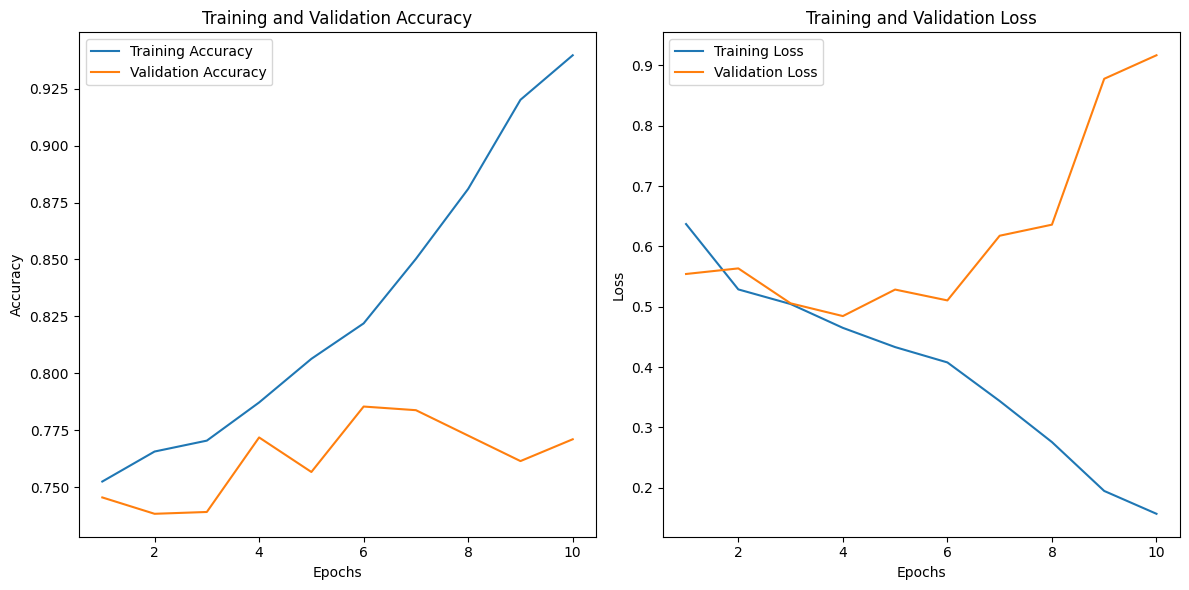

In [ ]:
# Parameters
img_width, img_height = 150, 150  # Dimensions to which the images are resized
batch_size = 32
epochs = 10
num_classes = 2  # Scales and No Scales

# Load the data from CSV
def load_dataset(csv_file_path):
    df = pd.read_csv(csv_file_path)
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = row['File_Path']
        category = row['Category']
        label = 1 if category == 'scales' else 0  # 1 for scales, 0 for no scales
        try:
            img = load_img(img_path, target_size=(img_width, img_height))
            img = img_to_array(img)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    images = np.array(images, dtype='float32')
    images /= 255  # Normalize to [0, 1]
    labels = np.eye(num_classes)[labels]  # Convert labels to one-hot encoding

    return images, labels

# Path to the classified CSV
csv_file_path = '/content/drive/MyDrive/Proyecto Final Itzel/renamed/classified_files.csv'  # Use the correct path to your CSV
images, labels = load_dataset(csv_file_path)

# Split the dataset
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_labels))

# Evaluate the model
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model
model_save_path = '/content/drive/MyDrive/Proyecto Final Itzel'
os.makedirs(model_save_path, exist_ok=True)  # Creates the directory if it doesn't exist

model_path = os.path.join(model_save_path, 'animal_scale_model.h5')
model.save(model_path)
print(f"Model saved successfully at {model_path}")

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# **6.**
In this part of code is the testing of new data to see the behaviour of the model. In this code we have multiples taks that were done. The first thing was load the trained model tha we developed before. after that we have a function to load the new images, predict the kind of class and show the image with the respective prediction. After that it is the path for the file with images and a loop to predict the images. The new data was collected from Unsplash.

References: Unsplash.(2024). Animals. Images. Unsplash. https://unsplash.com/s/photos/animals

1/1 [==============================] - 0s 103ms/step


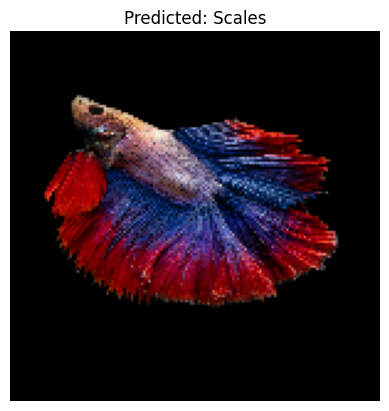

1/1 [==============================] - 0s 39ms/step


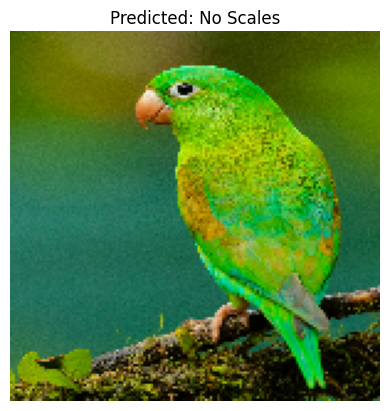

1/1 [==============================] - 0s 47ms/step


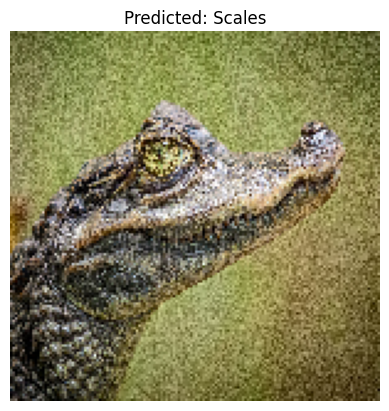

1/1 [==============================] - 0s 49ms/step


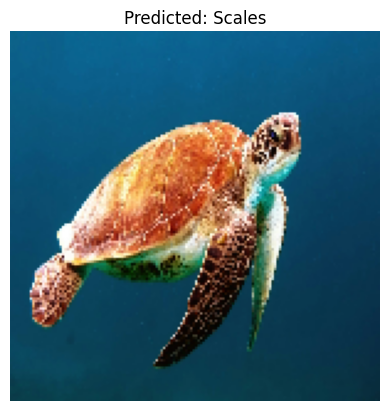

1/1 [==============================] - 0s 67ms/step


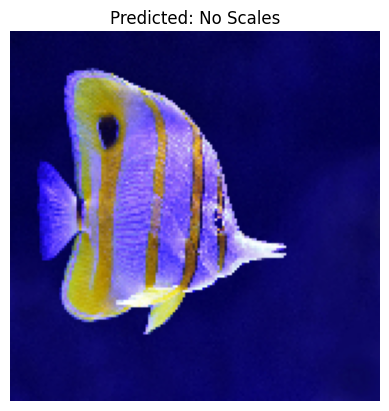

1/1 [==============================] - 0s 60ms/step


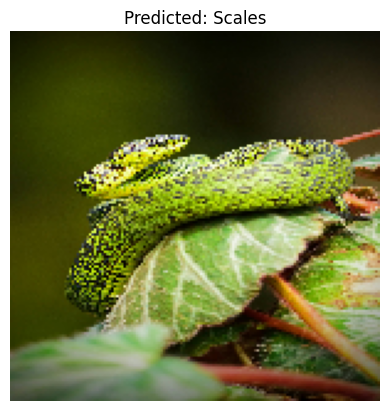

1/1 [==============================] - 0s 59ms/step


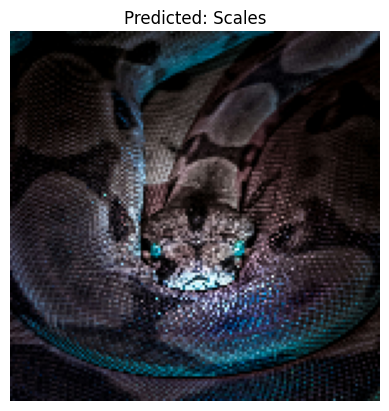

1/1 [==============================] - 0s 58ms/step


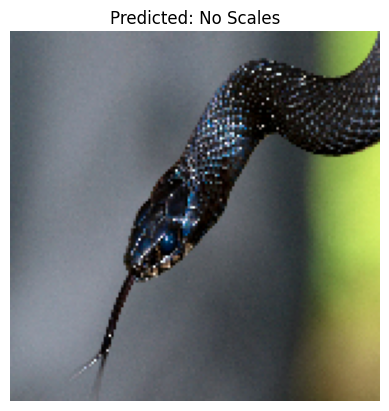

1/1 [==============================] - 0s 55ms/step


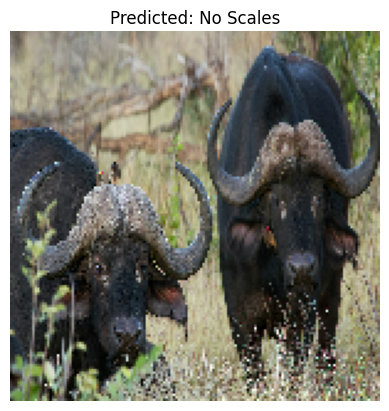

1/1 [==============================] - 0s 86ms/step


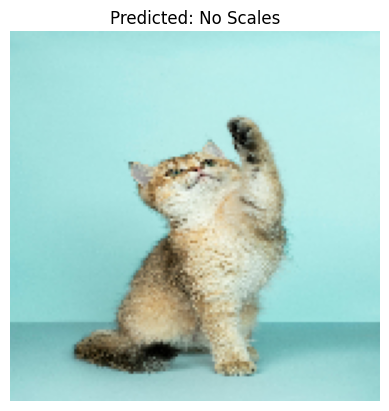

1/1 [==============================] - 0s 67ms/step


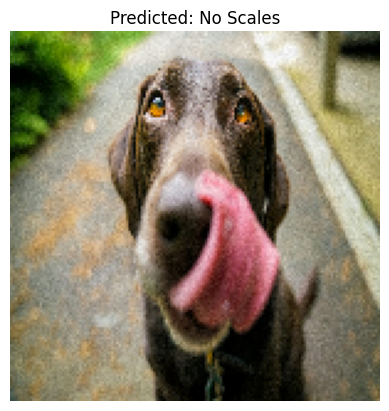

1/1 [==============================] - 0s 62ms/step


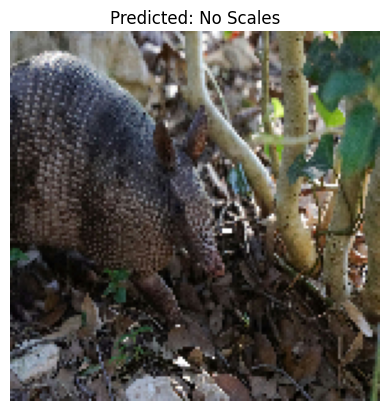

1/1 [==============================] - 0s 66ms/step


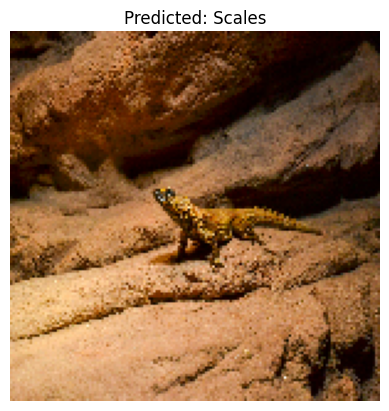

1/1 [==============================] - 0s 63ms/step


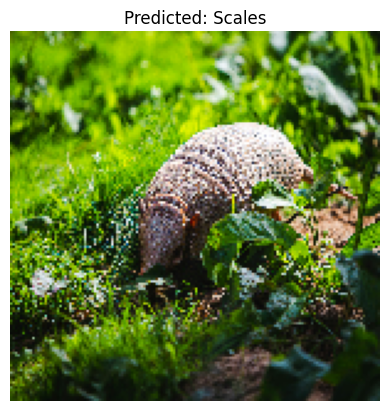

1/1 [==============================] - 0s 39ms/step


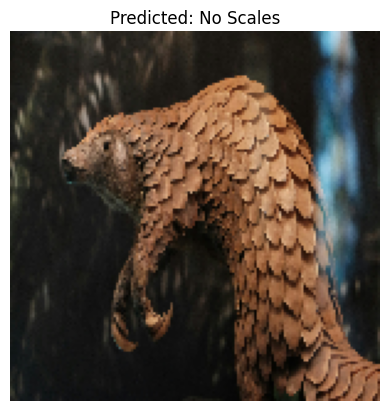

1/1 [==============================] - 0s 39ms/step


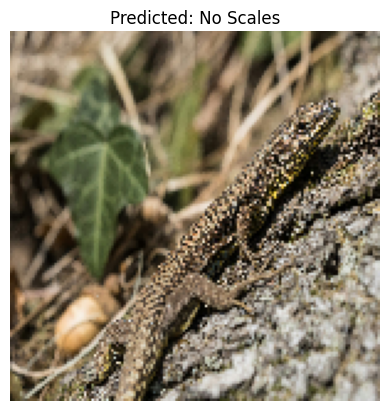

In [ ]:

# Load the trained model
model = load_model(os.path.join(model_save_path, 'animal_scale_model.h5'))

def predict_and_show_image(model, image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image array

    # Predict the class
    prediction = model.predict(img_array)
    class_indices = ['No Scales', 'Scales']
    predicted_class = class_indices[np.argmax(prediction)]

    # Show the image
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    return predicted_class

# Directory containing new images
image_directory = '/content/drive/MyDrive/Proyecto Final Itzel/new data'

# Loop through each file in the directory and predict if it's an image file
for filename in os.listdir(image_directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_directory, filename)
        predicted_class = predict_and_show_image(model, image_path)


# **7.**
In this last part of the code are the confusion matrix with the prediction with the new images. An also we have a pie chart were are the percentage of images with scales and no scales. To be able to do these graphs was neccesary to recall the model and images and see the predictions.

1/1 [==============================] - 0s 58ms/step


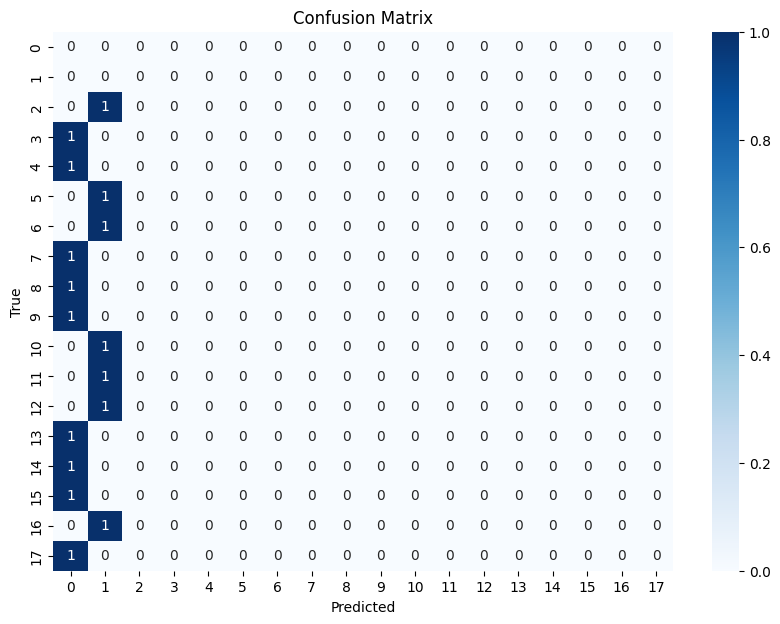

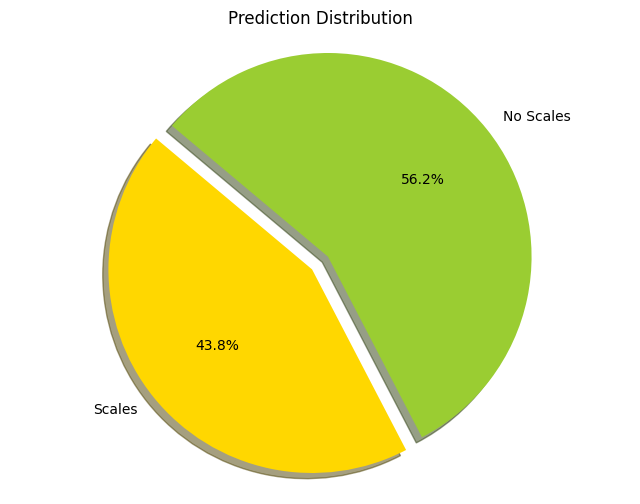

In [ ]:

def extract_label(filename):
    # The label is the first part of the filename before an underscore
    return filename.split('_')[0]

# 'y_true' holds the true labels and 'y_pred' holds the predicted labels
y_true = [extract_label(filename) for filename in os.listdir(image_directory) if filename.endswith((".jpg", ".png"))]

# Define the model loading and prediction function
def predict_and_show_image(model, image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image array

    prediction = model.predict(img_array)
    class_indices = ['No Scales', 'Scales']
    predicted_class = class_indices[np.argmax(prediction)]

    return predicted_class
model_save_path = '/content/drive/MyDrive/Proyecto Final Itzel'
# the model is loaded and you have defined img_width and img_height appropriately
model = load_model(os.path.join(model_save_path, 'animal_scale_model.h5'))

# Get predictions
y_pred = [predict_and_show_image(model, os.path.join(image_directory, filename)) for filename in os.listdir(image_directory) if filename.endswith((".jpg", ".png"))]

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#Pie Chart
# Count occurrences of each predicted class
predicted_counts = Counter(y_pred)
# Data to plot
labels = list(predicted_counts.keys())
sizes = list(predicted_counts.values())
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
colors = colors[:len(labels)]
explode = (0.1, 0) + (0,) * (len(labels) - 2)  # Explode the first slice and not the others
# Plot
plt.figure(figsize=(8,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Prediction Distribution')
plt.show()
